<a href="https://colab.research.google.com/github/v-artur/Golden_Oreos/blob/main/speaker_indep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fastdtw
!pip install pysptk
!pip install pyworld

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 276 kB 15.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pysptk: filename=pysptk-0.2.0-cp37-cp37m-linux_x86_64.whl size=931346 sha256=2afaf72b09e3bbc92253c0fbf9a40c16072b2b6168284ec6923a0ab1aa240357
  Stored in directory: /root/.cache/pip/wheels/9a/70/a1/757bd6c0017f384831e6260a784f10ff6d7998a805719f9a2d
Successfully built pysptk
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 214 kB 31.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pyworld: filename=py

In [2]:
#old links, because gdown is not reliable on the long run
#!pip install gdown
#!gdown https://drive.google.com/uc?id=1Uu55cqiSZLCj0fAU7QoXxJSIunsuqHEX
#!gdown https://drive.google.com/u/0/uc?id=1_eeG0d_r-RqazUkr-ZRPNC6L13sHYwIP
#!gdown https://drive.google.com/u/0/uc?id=1Bjf3ncRe8CcWHl3i0HxRo4unRYkz2fog



#the data
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1vtZchVzl424pSQBXQ8EBxvVOzcEQPKIp' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1vtZchVzl424pSQBXQ8EBxvVOzcEQPKIp" -O features.zip && rm -rf /tmp/cookies.txt
#reconstruction module
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1_eeG0d_r-RqazUkr-ZRPNC6L13sHYwIP' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1_eeG0d_r-RqazUkr-ZRPNC6L13sHYwIP" -O reconstructWave.py && rm -rf /tmp/cookies.txt
#Melfiltebank applier
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Bjf3ncRe8CcWHl3i0HxRo4unRYkz2fog' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Bjf3ncRe8CcWHl3i0HxRo4unRYkz2fog" -O MelFilterBank.py && rm -rf /tmp/cookies.txt


#extracting it
import zipfile
zip_ref = zipfile.ZipFile("/content/features.zip", 'r')
zip_ref.extractall("/content/features")
zip_ref.close()

--2022-11-23 21:50:08--  https://docs.google.com/uc?export=download&confirm=t&id=1vtZchVzl424pSQBXQ8EBxvVOzcEQPKIp
Resolving docs.google.com (docs.google.com)... 142.251.163.139, 142.251.163.138, 142.251.163.100, ...
Connecting to docs.google.com (docs.google.com)|142.251.163.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/o91mrcrspco86h2qcsvcfm19vd6eghpi/1669240200000/17895932938140350971/*/1vtZchVzl424pSQBXQ8EBxvVOzcEQPKIp?e=download&uuid=6d6c0d0b-e890-444b-b63d-59ecf3728b1d [following]
--2022-11-23 21:50:08--  https://doc-08-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/o91mrcrspco86h2qcsvcfm19vd6eghpi/1669240200000/17895932938140350971/*/1vtZchVzl424pSQBXQ8EBxvVOzcEQPKIp?e=download&uuid=6d6c0d0b-e890-444b-b63d-59ecf3728b1d
Resolving doc-08-9o-docs.googleusercontent.com (doc-08-9o-docs.googleusercontent.com)... 142.251.163.

In [3]:
#setting the path
feat_path = r'/content/features'

# the subjects for each set
train_subs = ['sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09','sub-10']
val_subs = ['sub-01', 'sub-02']
test_subs = ['sub-03', 'sub-04']

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import os

# making the train, validation and test sets with Principal Component Analysis 
def make_set(subs, n_comp):
  whole_data = []
  whole_spec = []

  for participant in subs:
    #features with PCA
    data = np.load(os.path.join(feat_path,f'{participant}_feat.npy'))
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    pca = PCA(n_components=n_comp, random_state=0)
    data = pca.fit_transform(data)
    whole_data.append(data)
    #labels
    spec = np.load(os.path.join(feat_path,f'{participant}_spec.npy'))
    whole_spec.append(spec)
  
  features = np.vstack(tuple(whole_data))
  labels = np.vstack(tuple(whole_spec))

  return features, labels

train_data, train_spec = make_set(train_subs, 300)
val_data, val_spec = make_set(val_subs, 300)

# Modeling

In [ ]:
#Setting seed
import tensorflow as tf
tf.keras.utils.set_random_seed(1234)

Simple FC-DNN model

In [ ]:
from tensorflow.keras import regularizers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Input

def create_dnn_model(inputsize, outputsize):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(inputsize)))
    model.add(tf.keras.layers.Dense(400, activation="relu", kernel_initializer='HeNormal'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(300, activation="relu", kernel_initializer='HeNormal'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(200, activation="relu", kernel_initializer='HeNormal'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(100, activation="relu", kernel_initializer='HeNormal'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(outputsize))
    return model

In [ ]:
early_stopping = EarlyStopping(patience=10, verbose=1, min_delta=1e-5)
checkpointer = ModelCheckpoint(filepath='weights.hdf5', save_best_only=True, verbose=1)

model = create_dnn_model(300, 23)
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
model.fit(train_data, train_spec, batch_size=64, 
          epochs=100, verbose=1, validation_data=(val_data, val_spec), shuffle=True,
          callbacks=[checkpointer, early_stopping])

Epoch 1/100
2786/2788 [============================>.] - ETA: 0s - loss: 3.8735 - mse: 3.8735
Epoch 1: val_loss improved from inf to 4.52493, saving model to weights.hdf5
2788/2788 [==============================] - 36s 13ms/step - loss: 3.8731 - mse: 3.8731 - val_loss: 4.5249 - val_mse: 4.5249
Epoch 2/100
2784/2788 [============================>.] - ETA: 0s - loss: 2.6128 - mse: 2.6128
Epoch 2: val_loss did not improve from 4.52493
2788/2788 [==============================] - 31s 11ms/step - loss: 2.6127 - mse: 2.6127 - val_loss: 4.7287 - val_mse: 4.7287
Epoch 3/100
2788/2788 [==============================] - ETA: 0s - loss: 2.2233 - mse: 2.2233
Epoch 3: val_loss did not improve from 4.52493
2788/2788 [==============================] - 32s 11ms/step - loss: 2.2233 - mse: 2.2233 - val_loss: 4.6746 - val_mse: 4.6746
Epoch 4/100
2787/2788 [============================>.] - ETA: 0s - loss: 1.9884 - mse: 1.9884
Epoch 4: val_loss did not improve from 4.52493
2788/2788 [====================

In [ ]:
model.load_weights('weights.hdf5')

In [ ]:
test_data3, test_spec3 = make_set(['sub-03'], 300)
test_data4, test_spec4 = make_set(['sub-04'], 300)

In [ ]:
rec_spec3 = model.predict(test_data3)
rec_spec4 = model.predict(test_data4)

938/938 [==============================] - 3s 3ms/step


In [ ]:
from scipy.stats import pearsonr
import scipy.io.wavfile as wavfile

rs3 = np.zeros((test_spec3.shape[1]))
rs4 = np.zeros((test_spec4.shape[1]))

# Evaluate reconstruction of this fold
for specBin in range(test_spec3.shape[1]):
  r, p = pearsonr(test_spec3[:, specBin], rec_spec4[:, specBin])
  rs3[specBin] = r

for specBin in range(test_spec4.shape[1]):
  r, p = pearsonr(test_spec4[:, specBin], rec_spec4[:, specBin])
  rs4[specBin] = r

#Show evaluation result
print('Mean correlation for participant 3:', np.mean(rs3))
print('Mean correlation for participant 4:', np.mean(rs4))

Mean correlation for participant 3: 0.17542258760402343
Mean correlation for participant 4: 0.09730239886412276


## MCD

In [ ]:
#For audio reconstruction and MCD measure 
#dependencies
import reconstructWave as rW
import MelFilterBank as mel
import numpy as np
import librosa
from scipy.io import wavfile
import pysptk
from scipy.spatial.distance import euclidean
import os
from fastdtw import fastdtw

# functions for MCD calculations 
# (source: https://github.com/ttslr/python-MCD?fbclid=IwAR2OFaz3-8kTfhJXC7F-cmTTHkY-egEzZdSYHsC0agwPw58N2G3hqhfdVNY)


#The following function converts a wav file into a format which can be used to evaluate the MCD score
def readmgc(filename):
    sr, x = wavfile.read(filename)
    assert sr == 16000
    x = x.astype(np.float64)
    frame_length = 1024
    hop_length = 256  
    frames = librosa.util.frame(x, frame_length=frame_length, hop_length=hop_length).astype(np.float64).T
    frames *= pysptk.blackman(frame_length)
    assert frames.shape[1] == frame_length 
    order = 25
    alpha = 0.41
    stage = 5
    gamma = -1.0 / stage

    mgc = pysptk.mgcep(frames, order, alpha, gamma)
    mgc = mgc.reshape(-1, order + 1)
    print("mgc of {} is ok!".format(filename))
    return mgc


# variable for the compute_mcd function 
natural_folder = '/content/features/'


#this function returns the average MCD score for the reconstructed WAV file by a chosen model
def compute_mcd(synth_folder):
  '''
  :param synth_folder: the folder in which the reconstructed WAV file can be found
  '''
  #computational parameters
  _logdb_const = 10.0 / np.log(10.0) * np.sqrt(2.0)
  s = 0.0
  framesTot = 0

  # computing the MCD
  files = os.listdir(synth_folder)
  for subject in files:
    print("Processing -----------{}".format(subject))
    

    # obtaining the mgc features
    subject_ID = subject[0:6]
    filename1 = natural_folder + subject_ID + '_orig_audio.wav'
    mgc1 = readmgc(filename1)
    filename2 = synth_folder + subject_ID + '_predicted.wav'
    mgc2 = readmgc(filename2)
  
    x = mgc1
    y = mgc2
    
    # calculating the mcd
    distance, path = fastdtw(x, y, dist=euclidean)
  
    distance/= (len(x) + len(y))
    pathx = list(map(lambda l: l[0], path))
    pathy = list(map(lambda l: l[1], path))
    x, y = x[pathx], y[pathy]

    frames = x.shape[0]
    framesTot  += frames

    z = x - y
    s += np.sqrt((z * z).sum(-1)).sum()

  MCD_value = _logdb_const * float(s) / float(framesTot)

  print("MCD = : {:f}".format(MCD_value))


#Reconstructing the WAV file from the predicted mel-log spectrogram (Griffin-Lim method)
def createAudio(spectrogram, audiosr=16000, winLength=0.05, frameshift=0.01):
    mfb = mel.MelFilterBank(int((audiosr*winLength)/2+1), spectrogram.shape[1], audiosr)
    hop = int(spectrogram.shape[0])
    rec_audio = np.array([])
    for_reconstruction = mfb.fromLogMels(spectrogram)
    for w in range(0,spectrogram.shape[0],hop):
        spec = for_reconstruction[w:min(w+hop,for_reconstruction.shape[0]),:]
        rec = rW.reconstructWavFromSpectrogram(spec,spec.shape[0]*spec.shape[1],fftsize=int(audiosr*winLength),overlap=int(winLength/frameshift))
        rec_audio = np.append(rec_audio,rec)
    scaled = np.int16(rec_audio/np.max(np.abs(rec_audio)) * 32767)
    return scaled

In [ ]:
import matplotlib.pyplot as plt
import librosa
import pyworld

In [ ]:
#Audio Reconstruction parameters
winLength = 0.05
frameshift = 0.01
audiosr = 16000

In [ ]:
#source: https://github.com/SamuelBroughton/Mel-Cepstral-Distortion/blob/master/mel-cepstral-distortion.ipynb
def load_wav(wav_file, sr):
    """
    Load a wav file with librosa.
    :param wav_file: path to wav file
    :param sr: sampling rate
    :return: audio time series numpy array
    """
    wav, _ = librosa.load(wav_file, sr=sr, mono=True)

    return wav

In [ ]:
#this folder will be needed for the evaluation
!mkdir synth_audio_dnn

mkdir: cannot create directory ‘synth_audio_dnn’: File exists


In [ ]:
reconstructedWav4 = createAudio(rec_spec4,audiosr=audiosr,winLength=winLength,frameshift=frameshift)
wavfile.write(os.path.join('/content/synth_audio_dnn/sub-04_predicted.wav'),int(audiosr),reconstructedWav4)

In [ ]:
orig_bn4 = load_wav('/content/features/sub-04_orig_audio.wav', 16000)
rec_bn4 = load_wav('/content/synth_audio_dnn/sub-04_predicted.wav', 16000)

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


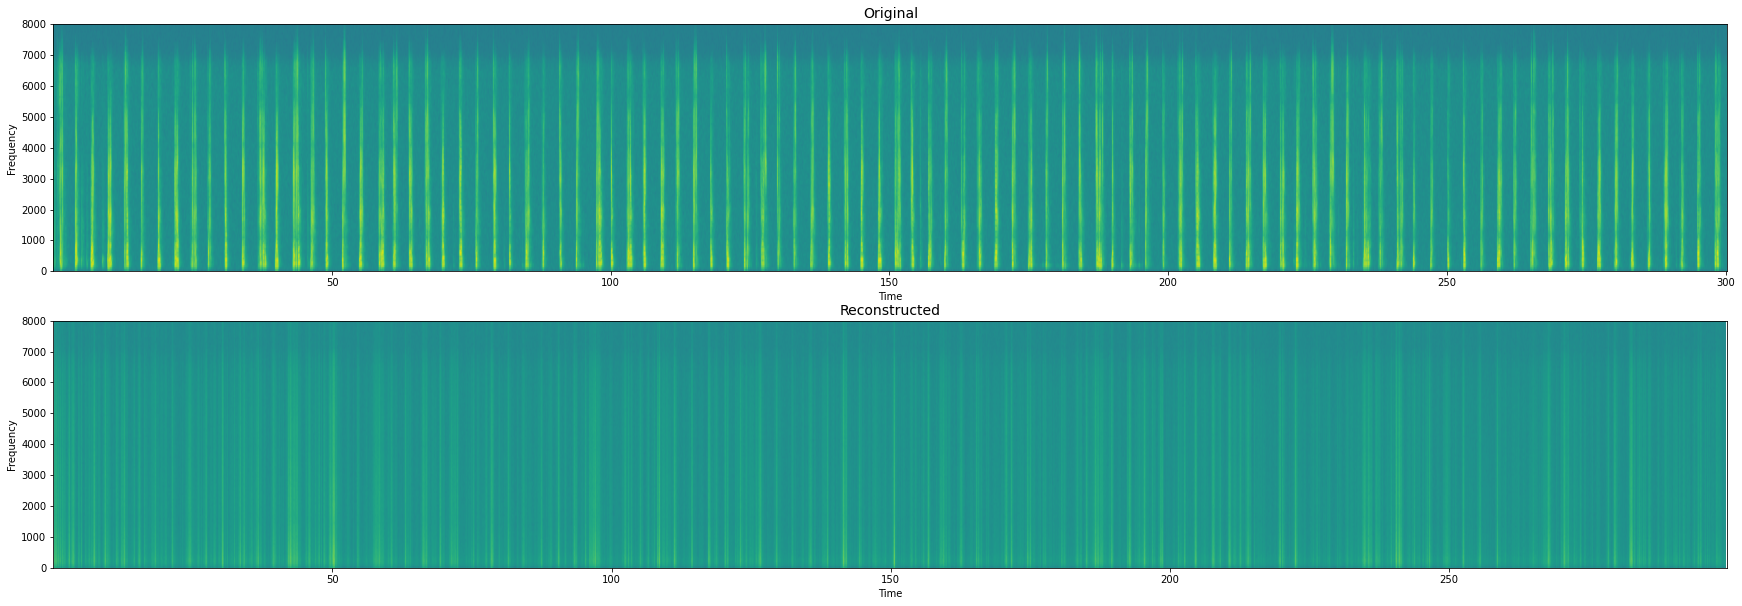

In [ ]:
#plotting the spectograms of the original sub-04_orig_audio.wav file and the reconstructed sub-04_predicted.wav file
plt.figure(figsize = (30,10))
plt.subplot(211)
plt.specgram(orig_bn4, Fs=16000)
plt.title('Original', fontsize=14)
plt.xlabel('Time')
plt.ylabel('Frequency') 

plt.subplot(212)
plt.specgram(rec_bn4, Fs=16000)
plt.title('Reconstructed', fontsize=14)
plt.xlabel('Time')
plt.ylabel('Frequency') 
plt.show()

In [ ]:
compute_mcd('/content/synth_audio_dnn/')

Processing -----------sub-04_predicted.wav
mgc of /content/features/sub-04_orig_audio.wav is ok!
mgc of /content/synth_audio_dnn/sub-04_predicted.wav is ok!
MCD = : 5.349841


If mcd throws an error (the directory contains ipynb checkpoints), run this and then from the CreateAudio function again.

In [ ]:
# import shutil
# folder = '/content/synth_audio_dnn'
# for filename in os.listdir(folder):
#     file_path = os.path.join(folder, filename)
#     try:
#         if os.path.isfile(file_path) or os.path.islink(file_path):
#             os.unlink(file_path)
#         elif os.path.isdir(file_path):
#             shutil.rmtree(file_path)
#     except Exception as e:
#         print('Failed to delete %s. Reason: %s' % (file_path, e))